In [1]:
library(ggplot2)
library(ggthemes)
library(gridExtra)
library(matrixStats)
library(onehot)
library(zoo)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [2]:
path <- './bike-sharing-day.csv'
df <- read.csv(file = path, header = TRUE)
df$dteday <- as.Date(df$dteday, '%Y-%m-%d')
head(df, 5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
,<int>,<date>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


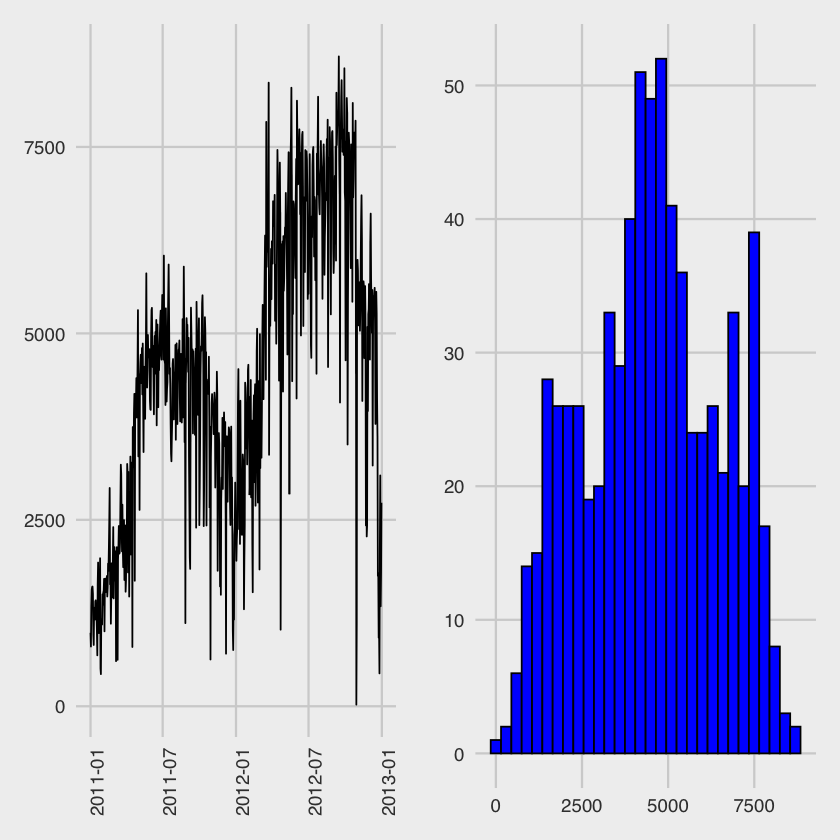

In [3]:
ts <- {ggplot(df, aes(dteday, cnt)) +
    geom_line() +
    scale_color_fivethirtyeight() +
    theme_fivethirtyeight(base_size = 14) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))}

hg <- {ggplot(df, aes(cnt)) +
    geom_histogram(bins = 30, col='black', fill='blue') +
    scale_color_fivethirtyeight() +
    theme_fivethirtyeight(base_size = 14)}

grid.arrange(ts, hg, nrow = 1)

In [4]:
df_model <- subset(df, select = -c(instant, casual, registered, atemp, workingday))
head(df_model, 5)

,dteday,season,yr,mnth,holiday,weekday,weathersit,temp,hum,windspeed,cnt
,<date>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,2011-01-01,1,0,1,0,6,2,0.344167,0.805833,0.160446,985
2,2011-01-02,1,0,1,0,0,2,0.363478,0.696087,0.248539,801
3,2011-01-03,1,0,1,0,1,1,0.196364,0.437273,0.248309,1349
4,2011-01-04,1,0,1,0,2,1,0.200000,0.590435,0.160296,1562
5,2011-01-05,1,0,1,0,3,1,0.226957,0.436957,0.186900,1600


In [5]:
cols_factor <- c('season', 'mnth', 'weekday', 'weathersit')
for (c in cols_factor) {
  df_model[, c] <- as.factor(df_model[, c])
}
head(df_model, 5)

,dteday,season,yr,mnth,holiday,weekday,weathersit,temp,hum,windspeed,cnt
,<date>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>
1,2011-01-01,1,0,1,0,6,2,0.344167,0.805833,0.160446,985
2,2011-01-02,1,0,1,0,0,2,0.363478,0.696087,0.248539,801
3,2011-01-03,1,0,1,0,1,1,0.196364,0.437273,0.248309,1349
4,2011-01-04,1,0,1,0,2,1,0.200000,0.590435,0.160296,1562
5,2011-01-05,1,0,1,0,3,1,0.226957,0.436957,0.186900,1600


In [6]:
encoder <- onehot(df_model, max_levels = 100)
df_model <- data.frame(predict(encoder, df_model))
df_model <- subset(df_model, 
                   select = -c(season.1, mnth.1, weekday.0, weathersit.1))
df_model$intercept <- 1
head(df_model, 5)

,dteday,season.2,season.3,season.4,yr,mnth.2,mnth.3,mnth.4,mnth.5,mnth.6,⋯,weekday.4,weekday.5,weekday.6,weathersit.2,weathersit.3,temp,hum,windspeed,cnt,intercept
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14975,0,0,0,0,0,0,0,0,0,⋯,0,0,1,1,0,0.344167,0.805833,0.160446,985,1
2,14976,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0.363478,0.696087,0.248539,801,1
3,14977,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0.196364,0.437273,0.248309,1349,1
4,14978,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0.200000,0.590435,0.160296,1562,1
5,14979,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0.226957,0.436957,0.186900,1600,1


In [7]:
n <- nrow(df_model)

train <- df_model[1:700, ]
test <- df_model[701:n, ]

print(nrow(train))
print(nrow(test))

[1] 700
[1] 31


In [8]:
lm <- lm(cnt ~ . - 1 - dteday, data = train)
summary(lm)

lres <- lm$residuals


Call:
lm(formula = cnt ~ . - 1 - dteday, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-4042.8  -355.2    74.3   452.7  2824.5 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
season.2       719.20     182.23   3.947 8.76e-05 ***
season.3       509.09     227.33   2.239 0.025456 *  
season.4      1046.58     225.90   4.633 4.33e-06 ***
yr            2084.92      60.26  34.598  < 2e-16 ***
mnth.2         156.87     141.95   1.105 0.269513    
mnth.3         650.20     164.84   3.944 8.84e-05 ***
mnth.4         691.10     249.94   2.765 0.005847 ** 
mnth.5         987.13     271.01   3.642 0.000291 ***
mnth.6         838.11     288.68   2.903 0.003814 ** 
mnth.7         474.89     327.77   1.449 0.147845    
mnth.8         857.79     316.12   2.713 0.006828 ** 
mnth.9        1459.98     286.11   5.103 4.36e-07 ***
mnth.10       1115.68     280.93   3.971 7.92e-05 ***
mnth.11        458.74     269.52   1.702 0.089210 .  
mnth.12        638.59    

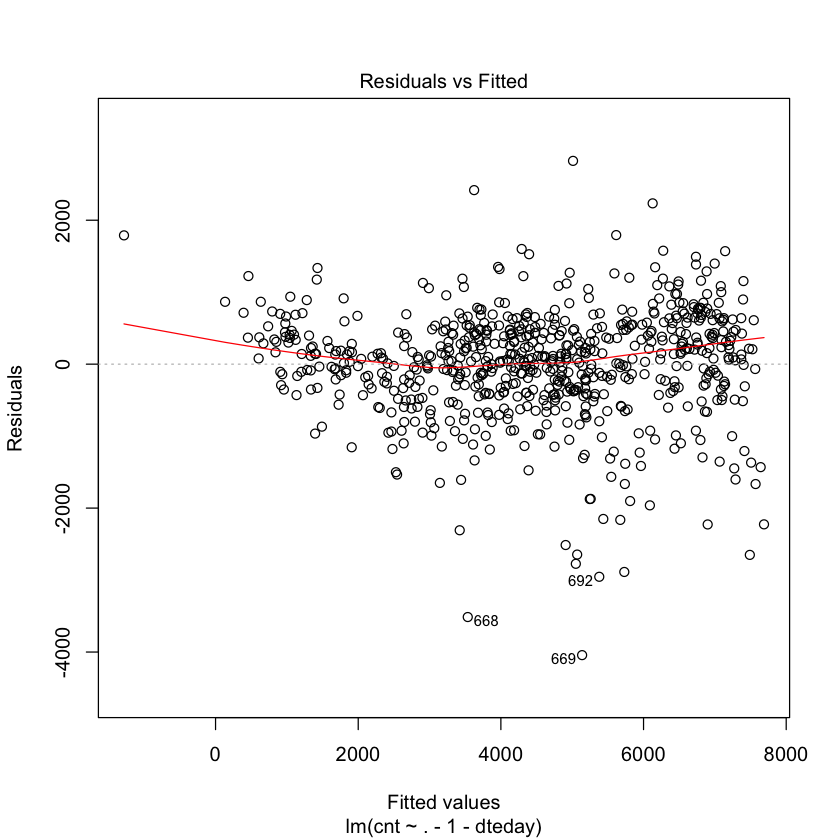

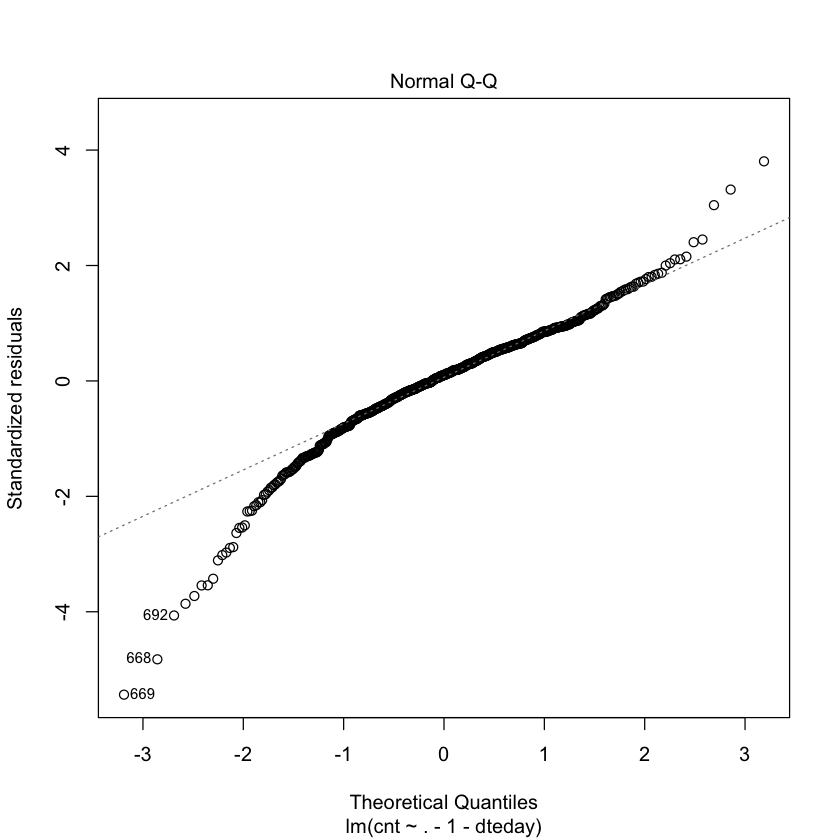

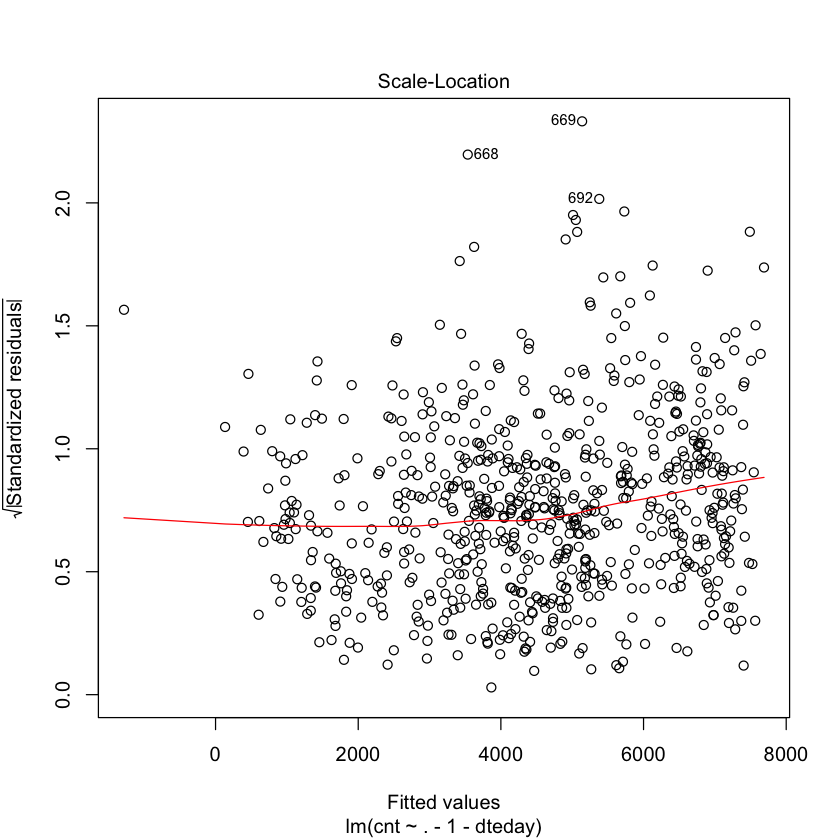

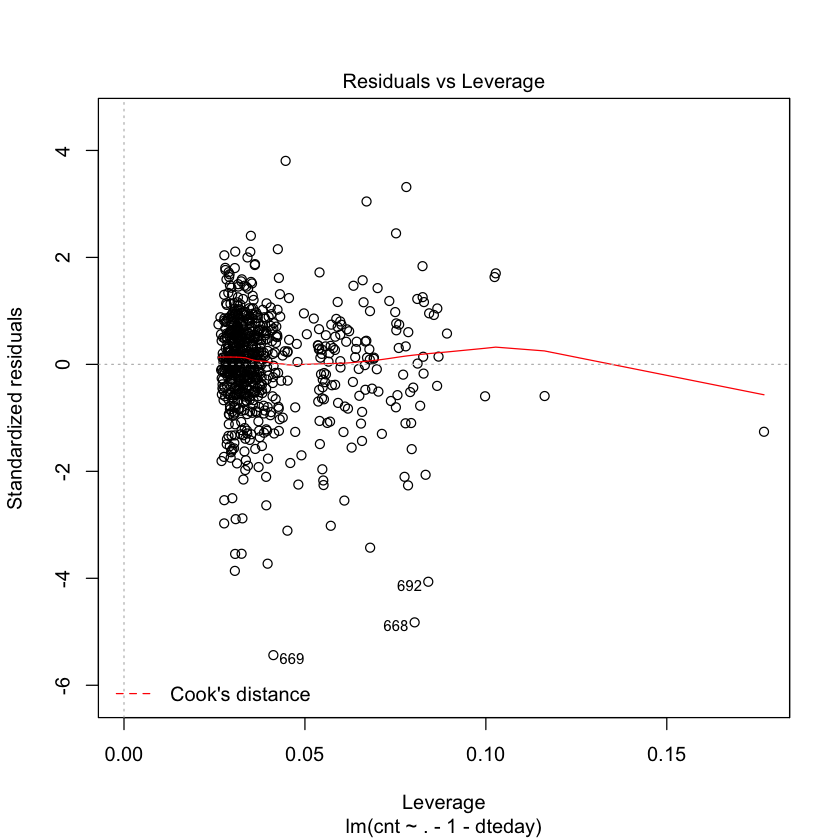

In [9]:
plot(lm)

In [10]:
lm_pred <- predict(lm, test, interval="predict")
test_pred <- cbind(test, lm_pred)
head(test_pred, 5)

,dteday,season.2,season.3,season.4,yr,mnth.2,mnth.3,mnth.4,mnth.5,mnth.6,⋯,weathersit.2,weathersit.3,temp,hum,windspeed,cnt,intercept,fit,lwr,upr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
701,15675,0,0,1,1,0,0,0,0,0,⋯,1,0,0.298333,0.806667,0.0597042,5191,1,5209.469,3670.201,6748.738
702,15676,0,0,1,1,0,0,0,0,0,⋯,1,0,0.347500,0.823333,0.1243790,4649,1,4786.241,3248.397,6324.085
703,15677,0,0,1,1,0,0,0,0,0,⋯,0,0,0.452500,0.767500,0.0827208,6234,1,6054.318,4513.539,7595.097
704,15678,0,0,1,1,0,0,0,0,0,⋯,0,0,0.475833,0.733750,0.1741290,6606,1,6018.392,4478.606,7558.178
705,15679,0,0,1,1,0,0,0,0,0,⋯,0,0,0.438333,0.485000,0.3240210,5729,1,5857.318,4314.401,7400.234


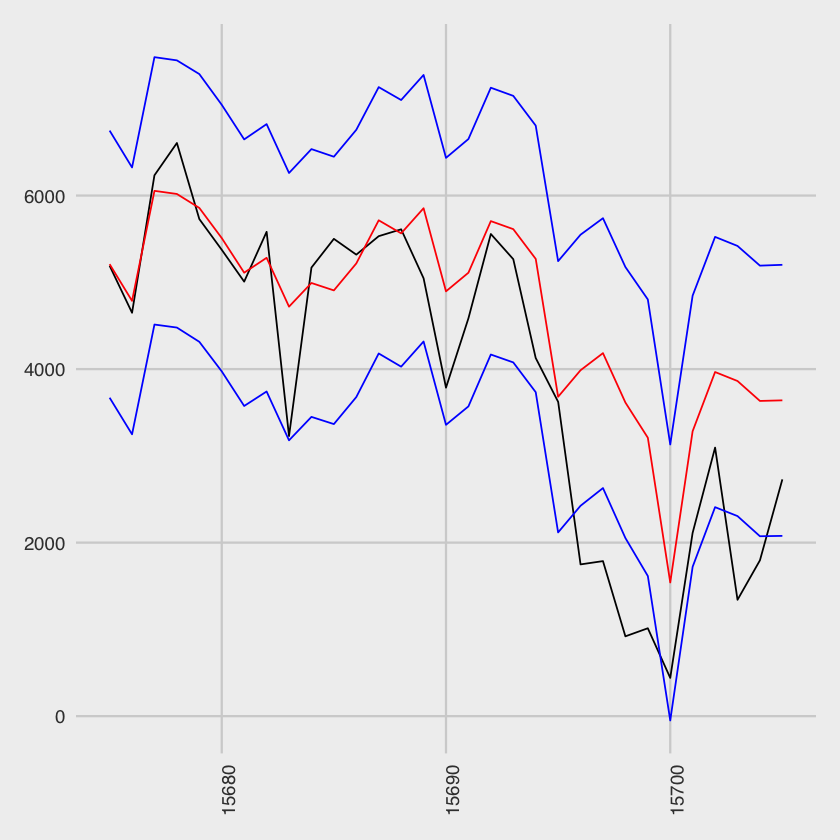

In [11]:
ggplot(test_pred) +
  geom_line(aes(dteday, cnt), col = 'black') + 
  geom_line(aes(dteday, fit), col = 'red') + 
  geom_line(aes(dteday, lwr), col = 'blue') +
  geom_line(aes(dteday, upr), col = 'blue') + 
  scale_color_fivethirtyeight() +
  theme_fivethirtyeight(base_size = 14) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [12]:
run_boot <- function(dtrain, dtest) {
  d <- dtrain[sample(1:nrow(dtrain), size = nrow(dtrain), replace = TRUE), ]
  
  mod <- lm(cnt ~ . - 1 - dteday, data = d)
  
  ptrain <- predict(mod, d)
  ptest <- predict(mod, dtest)
  
  res_ss <- d$cnt - ptrain
  return(ptest + sample(res_ss, size = length(ptest), replace = TRUE))
}

In [13]:
boots <- replicate(n=2500, run_boot(dtrain = train, dtest = test))

In [14]:
qboot <- data.frame(rowQuantiles(boots, probs = c(0.025, 0.5, 0.975)))
colnames(qboot) <- c('blwr', 'median', 'bupr')
test_pred <- cbind(test_pred, qboot)
head(test_pred, 5)

,dteday,season.2,season.3,season.4,yr,mnth.2,mnth.3,mnth.4,mnth.5,mnth.6,⋯,hum,windspeed,cnt,intercept,fit,lwr,upr,blwr,median,bupr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
701,15675,0,0,1,1,0,0,0,0,0,⋯,0.806667,0.0597042,5191,1,5209.469,3670.201,6748.738,3381.980,5285.820,6438.126
702,15676,0,0,1,1,0,0,0,0,0,⋯,0.823333,0.1243790,4649,1,4786.241,3248.397,6324.085,3129.432,4846.061,6017.726
703,15677,0,0,1,1,0,0,0,0,0,⋯,0.767500,0.0827208,6234,1,6054.318,4513.539,7595.097,4321.903,6113.882,7390.593
704,15678,0,0,1,1,0,0,0,0,0,⋯,0.733750,0.1741290,6606,1,6018.392,4478.606,7558.178,4177.628,6059.264,7257.624
705,15679,0,0,1,1,0,0,0,0,0,⋯,0.485000,0.3240210,5729,1,5857.318,4314.401,7400.234,4243.969,5949.674,7194.585


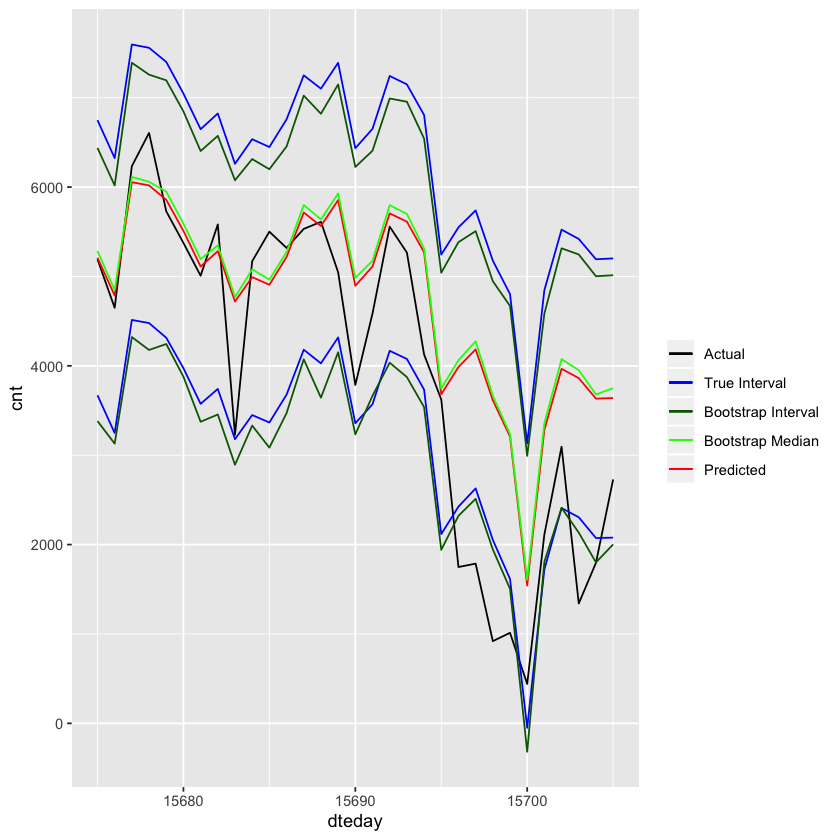

In [15]:
ggplot(test_pred) +
  geom_line(aes(dteday, cnt, color = 'black')) + 
  geom_line(aes(dteday, fit, color = 'red')) + 
  geom_line(aes(dteday, lwr, color = 'blue')) +
  geom_line(aes(dteday, upr, color = 'blue')) +
  geom_line(aes(dteday, median, color = 'green')) +
  geom_line(aes(dteday, blwr, color = 'darkgreen')) +
  geom_line(aes(dteday, bupr, color = 'darkgreen')) + 
  scale_colour_manual(
    name = '', 
    values =c('black'='black', 'blue'='blue', 'darkgreen'='darkgreen', 
              'green'='green', 'red'='red'), 
    labels = c('Actual', 'True Interval', 'Bootstrap Interval', 
               'Bootstrap Median', 'Predicted'))